In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl

In [2]:
mpl.rcParams['xtick.labelsize'] = 14
mpl.rcParams['ytick.labelsize'] = 14
mpl.rcParams['axes.labelsize'] = 16
mpl.rcParams['axes.titlesize'] = 20
COLORS = [(44/255, 160/255, 44/255, 1), 
          (255/255, 127/255, 14/255, 1), 
          (214/255, 39/255, 40/255, 1), 
          (31/255, 119/255, 180/255, 1)]

In [3]:
df = pd.read_csv('./out/database.csv')

In [4]:
games_total = list()
for row in df['gid'].unique():
    games_total.append(df[df['gid'] == row]['game'].values[0])
    
games_names = list(set(games_total))
list1 = list()
list2 = list()
for i in games_names:
    print(i,games_total.count(i))
    list1.append(i)
    list2.append(games_total.count(i))
    
total_partidas_jogo = pd.DataFrame({'Games':list1,'Total':list2})

Encantados 13
Munchkin 6
Oh my goods 5
Kariba 8
Port Royal 21
Saboteur 4
Ninja Camp 8
Lhama 32
Bohnanza 14


In [5]:
def render_mpl_table(data, col_width=3.0, row_height=0.625, font_size=14,
                     header_color='#40466e', row_colors=['#f1f1f2', 'w'], edge_color='w',
                     bbox=[0, 0, 1, 1], header_columns=0,
                     ax=None, **kwargs):
    if ax is None:
        size = (np.array(data.shape[::-1]) + np.array([0, 1])) * np.array([col_width, row_height])
        fig, ax = plt.subplots(figsize=size)
        ax.axis('off')
    mpl_table = ax.table(cellText=data.values, bbox=bbox, colLabels=data.columns, **kwargs)
    mpl_table.auto_set_font_size(False)
    mpl_table.set_fontsize(font_size)

    for k, cell in mpl_table._cells.items():
        cell.set_edgecolor(edge_color)
        if k[0] == 0 or k[1] < header_columns:
            cell.set_text_props(weight='bold', color='w')
            cell.set_facecolor(header_color)
        else:
            cell.set_facecolor(row_colors[k[0]%len(row_colors) ])
    return ax.get_figure(), ax

In [6]:
winners = list()
for row in df['gid'].unique():
    winners.append(df[df['gid'] == row]['winner'].values[0])

In [7]:
games_by_players = df.groupby(['game', 'players']).agg({'players': ['count']})#.reset_index()
games_by_players.head()

players
                     count
game       players        
Bohnanza   Adriano       8
           Arturo       14
           David         9
           Isela        14
Encantados Adriano       9

In [8]:
total_games = games_by_players['players'].groupby(['players']).agg({'count': 'sum'})
total_games.head()

,count
players,
Adriano,57
Arturo,111
David,78
Isela,111


In [9]:
players_names = df['players'].unique()

total_efficience = dict()
hist_winners = dict()

for player in players_names:
    player_df = total_games.loc[player]['count']
    victories = len(list(
        filter(
            lambda i: i == player, winners
        )
    ))
    total_efficience[player] = (victories/player_df)*100
    hist_winners[player] = victories

In [10]:
game_efficience = dict(game = list(), player = list(), efficience = list())
for player in df['players'].unique():
    for game in df['game'].unique():
        vic = df.query("game == '{0}' and players == '{1}' and winner == '{1}'".format(game, player))
        try:
            par = games_by_players.loc[game].loc[player][0]
            game_efficience['game'].append(game)
            game_efficience['player'].append(player)
            game_efficience['efficience'].append((vic.count()[0]/par)*100)
        except KeyError:
            game_efficience['game'].append(game)
            game_efficience['player'].append(player)
            game_efficience['efficience'].append(0)

game_efficience = pd.DataFrame(game_efficience).astype({'efficience': int})
game_efficience.head()

,game,player,efficience
0,Lhama,David,45
1,Port Royal,David,20
2,Munchkin,David,0
3,Encantados,David,16
4,Saboteur,David,0


In [11]:
game_pivot = game_efficience.pivot("game", "player", "efficience")
game_pivot

player,Adriano,Arturo,David,Isela
game,,,,
Bohnanza,0,21,11,71
Encantados,11,53,16,30
Kariba,50,25,25,37
Lhama,26,31,45,21
Munchkin,0,50,0,50
Ninja Camp,33,75,12,0
Oh my goods,0,60,0,40
Port Royal,10,71,20,9
Saboteur,0,100,0,0


In [12]:
# Agregando la columna Game a game_pivot
idx = 0
new_col = ('Bohnanza','Encantados','Lhama','Munchkin','Ninja Camp','Port Royal','Saboteur','Kariba','Oh my goods')
game_pivot.insert(loc=idx, column='Game', value=new_col)
game_pivot

player,Game,Adriano,Arturo,David,Isela
game,,,,,
Bohnanza,Bohnanza,0,21,11,71
Encantados,Encantados,11,53,16,30
Kariba,Lhama,50,25,25,37
Lhama,Munchkin,26,31,45,21
Munchkin,Ninja Camp,0,50,0,50
Ninja Camp,Port Royal,33,75,12,0
Oh my goods,Saboteur,0,60,0,40
Port Royal,Kariba,10,71,20,9
Saboteur,Oh my goods,0,100,0,0


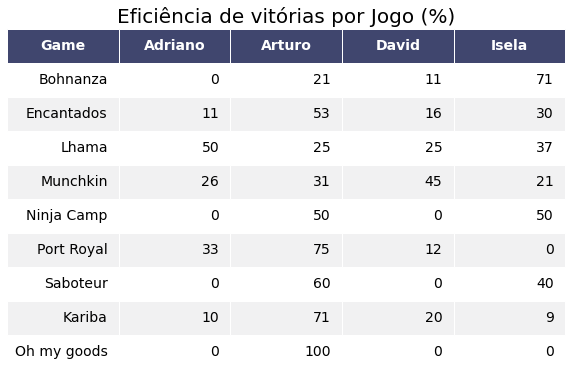

In [13]:
fig,ax = render_mpl_table(game_pivot, header_columns=0, col_width=2.0)
plt.title('Eficiência de vitórias por Jogo (%)')
fig.savefig("./fig/Eficiencia_por_jogo_table.png",facecolor='w',bbox_inches ='tight',pad_inches=0.1)

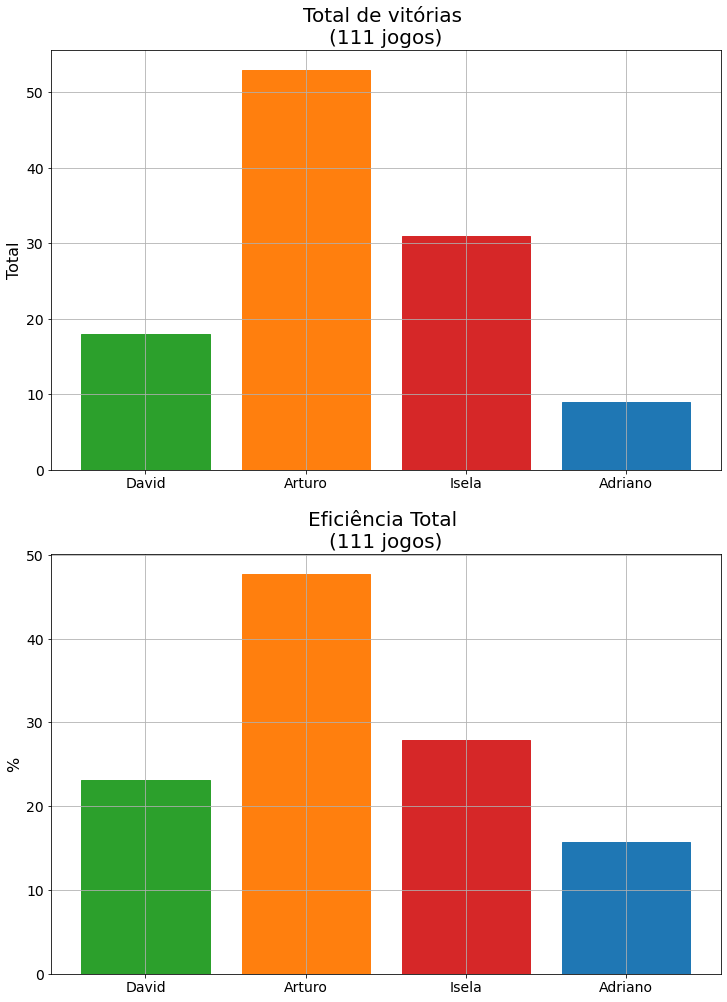

In [14]:
fig, ax = plt.subplots(2, 1, figsize=(12, 17))
ax[0].grid()
bars = ax[0].bar(hist_winners.keys(), hist_winners.values())
for i, color in enumerate(COLORS):
    bars[i].set_color(color)
ax[0].set_title('Total de vitórias \n(%d jogos)'%sum(hist_winners.values()))
ax[0].set_ylabel('Total')

ax[1].grid()
bars = ax[1].bar(total_efficience.keys(), total_efficience.values())
for i, color in enumerate(COLORS):
    bars[i].set_color(color)
ax[1].set_title('Eficiência Total \n(%d jogos)'%sum(hist_winners.values()))
ax[1].set_ylabel('%')

plt.savefig('./fig/general_statistics.png',facecolor='w',bbox_inches ='tight',pad_inches=0.1)

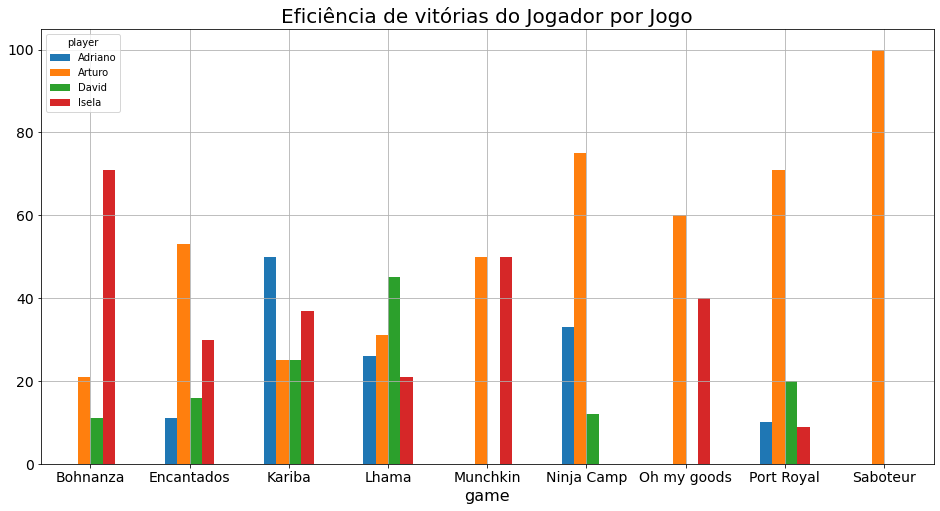

In [15]:
_, ax = plt.subplots(figsize=(16,8))
bars = game_pivot.plot(kind='bar', grid=True, ax=ax)
ax.tick_params(axis='x', rotation=0)
plt.title('Eficiência de vitórias do Jogador por Jogo')
plt.savefig("./fig/eficiencia_por_jogo.png",facecolor='w',bbox_inches ='tight',pad_inches=0.1)

David
Total de partidas:  78
Numero de Janelas:  7
[30, 50, 20, 20, 20, 10, 20]

Arturo
Total de partidas:  111
Numero de Janelas:  11
[20, 50, 60, 50, 60, 50, 40, 60, 40, 40, 60]

Isela
Total de partidas:  111
Numero de Janelas:  11
[50, 0, 20, 30, 20, 10, 40, 30, 30, 40, 40]

Adriano
Total de partidas:  57
Numero de Janelas:  5
[20, 20, 10, 10, 20]



<ipython-input-16-d13fce4a603f>:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['%i' % np.round(y) for y in vals])


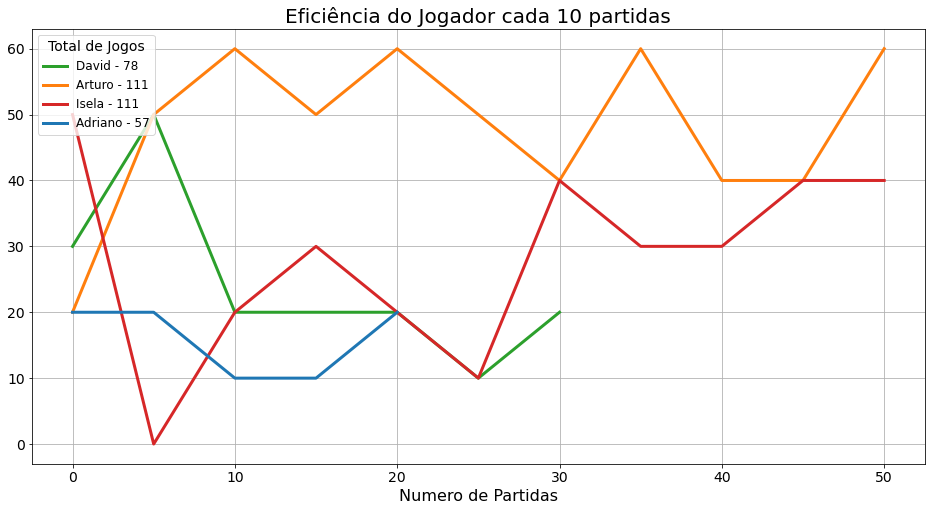

In [16]:
JN = 10
a = 0
df1 = df[['players', 'winner']]

plt.figure(figsize=(16,8))
ax = plt.axes()
for names in df1['players'].unique():

    print(names)

    test = dict()
    test = df1[df1['players'] == names]
    test.reset_index(drop=True, inplace=True)
    test.head()

    total_partidas_final = len(test)
    janelas = int(total_partidas_final/JN)
    print('Total de partidas: ',total_partidas_final)
    print('Numero de Janelas: ',janelas)

    list_player = list()
    for ii in range(janelas):
        list_player.append(int(((len(test[JN*ii:JN*ii+JN][test[JN*ii:JN*ii+JN]['winner'] == names]))/JN)*100))
    print(list_player)
    print()

    label_j = names +' - '+str(total_partidas_final)
    
    plt.plot(list_player,linestyle='-',linewidth=3,color=COLORS[a],label=label_j)
    
    a = a + 1

vals = ax.get_yticks()
ax.set_xticklabels(['%i' % np.round(y) for y in vals])    

plt.title('Eficiência do Jogador cada '+str(JN)+' partidas')
plt.xlabel('Numero de Partidas')
plt.grid(True)

leg = plt.legend(fontsize=12,loc=2)
leg.set_title(title="Total de Jogos",prop={'size':14})

salida1 = './fig/eficiencia_cada_'+str(JN)+'.png'

plt.savefig(salida1,facecolor='w',bbox_inches ='tight',pad_inches=0.1)

David
Total de partidas:  78
Numero de Janelas:  5
[26, 40, 20, 13, 20]

Arturo
Total de partidas:  111
Numero de Janelas:  7
[40, 46, 46, 60, 46, 46, 53]

Isela
Total de partidas:  111
Numero de Janelas:  7
[33, 13, 33, 6, 33, 33, 33]

Adriano
Total de partidas:  57
Numero de Janelas:  3
[13, 20, 20]



<ipython-input-17-f3f62e205b0a>:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['%i' % np.round(y) for y in vals])


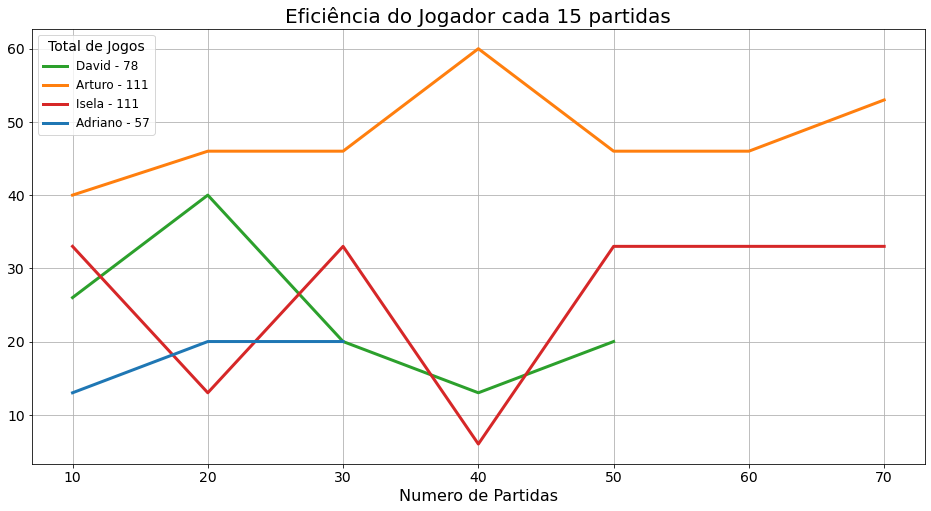

In [17]:
JN = 15
a = 0
df1 = df[['players', 'winner']]

plt.figure(figsize=(16,8))
ax = plt.axes()
for names in df1['players'].unique():

    print(names)

    test = dict()
    test = df1[df1['players'] == names]
    test.reset_index(drop=True, inplace=True)
    test.head()

    total_partidas_final = len(test)
    janelas = int(total_partidas_final/JN)
    print('Total de partidas: ',total_partidas_final)
    print('Numero de Janelas: ',janelas)

    list_player = list()
    for ii in range(janelas):
        list_player.append(int(((len(test[JN*ii:JN*ii+JN][test[JN*ii:JN*ii+JN]['winner'] == names]))/JN)*100))
    print(list_player)
    print()

    label_j = names +' - '+str(total_partidas_final)
    
    plt.plot(list_player,linestyle='-',linewidth=3,color=COLORS[a],label=label_j)
    
    a = a + 1

vals = ax.get_yticks()
ax.set_xticklabels(['%i' % np.round(y) for y in vals])    

plt.title('Eficiência do Jogador cada '+str(JN)+' partidas')
plt.xlabel('Numero de Partidas')
plt.grid(True)

leg = plt.legend(fontsize=12,loc=2)
leg.set_title(title="Total de Jogos",prop={'size':14})

salida2 = './fig/eficiencia_cada_'+str(JN)+'.png'

plt.savefig(salida2,facecolor='w',bbox_inches ='tight',pad_inches=0.1)

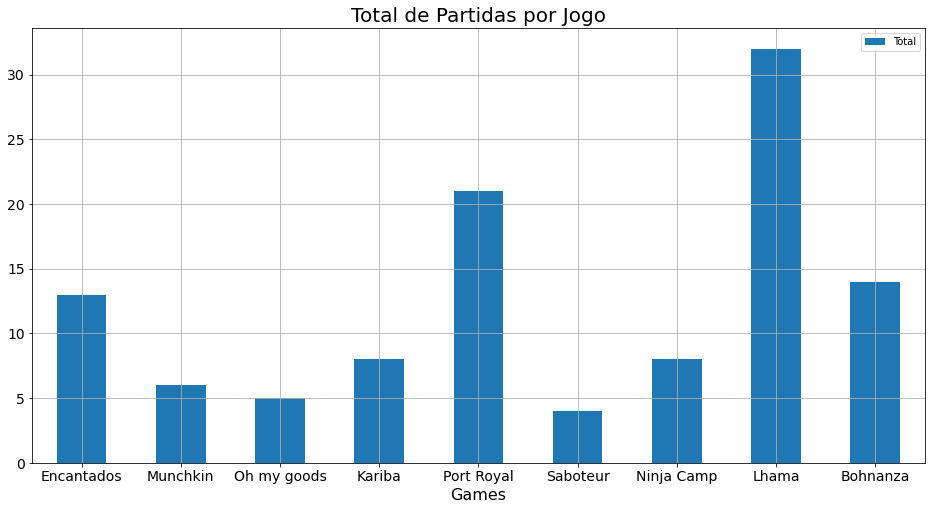

In [18]:
_, ax = plt.subplots(figsize=(16,8))
total_partidas_jogo.plot.bar(x='Games',grid=True,y='Total',ax=ax)
ax.tick_params(axis='x', rotation=0)
plt.title('Total de Partidas por Jogo')
plt.savefig("./fig/Total_partidas.png",facecolor='w',bbox_inches ='tight',pad_inches=0.1)